<a href="https://colab.research.google.com/github/Lahari1421/Temple-Architecture-Analysis/blob/main/Temple_Architecture_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import hashlib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# List of temple style folders
folders = [
    "/content/drive/My Drive/TempleDataset/Dravidian",
    "/content/drive/My Drive/TempleDataset/Nagara",
    "/content/drive/My Drive/TempleDataset/Vesara"
]

# Function to generate hash of a file
def get_file_hash(file_path):
    hasher = hashlib.md5()
    with open(file_path, "rb") as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

# Process each folder
for path in folders:
    hash_dict = {}
    duplicates = []
    total_images = 0

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
                total_images += 1
                file_path = os.path.join(root, file)

                file_hash = get_file_hash(file_path)

                if file_hash in hash_dict:
                    duplicates.append(file_path)
                    os.remove(file_path)  # Permanently remove duplicate
                else:
                    hash_dict[file_hash] = file_path

    print(f"Folder: {path}")
    print("Total Images (before deduplication):", total_images)
    print("Unique Images (after deduplication):", len(hash_dict))
    print("Duplicates Removed:", len(duplicates))
    print("-" * 50)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder: /content/drive/My Drive/TempleDataset/Dravidian
Total Images (before deduplication): 492
Unique Images (after deduplication): 492
Duplicates Removed: 0
--------------------------------------------------
Folder: /content/drive/My Drive/TempleDataset/Nagara
Total Images (before deduplication): 491
Unique Images (after deduplication): 491
Duplicates Removed: 0
--------------------------------------------------
Folder: /content/drive/My Drive/TempleDataset/Vesara
Total Images (before deduplication): 491
Unique Images (after deduplication): 491
Duplicates Removed: 0
--------------------------------------------------


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from google.colab import files

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import glob

# Mount Google Drive
drive.mount('/content/drive')

# --- Define the direct paths to your data folders ---
dravidian_path = "/content/drive/My Drive/TempleDataset/Dravidian"
nagara_path = "/content/drive/My Drive/TempleDataset/Nagara"
vesara_path = "/content/drive/My Drive/TempleDataset/Vesara"

# --- Parameters ---
batch_size = 32
img_height = 224
img_width = 224
AUTOTUNE = tf.data.AUTOTUNE

# --- Load all image paths and create labels ---
dravidian_files = glob.glob(os.path.join(dravidian_path, '*'))
nagara_files = glob.glob(os.path.join(nagara_path, '*'))
vesara_files = glob.glob(os.path.join(vesara_path, '*'))

# Combine all file paths
all_image_paths = dravidian_files + nagara_files + vesara_files

# Create labels corresponding to the files (0 for Dravidian, 1 for Nagara, 2 for Vesara)
class_names = ['Dravidian', 'Nagara', 'Vesara']
dravidian_labels = [0] * len(dravidian_files)
nagara_labels = [1] * len(nagara_files)
vesara_labels = [2] * len(vesara_files)
all_image_labels = dravidian_labels + nagara_labels + vesara_labels

print(f"Found {len(all_image_paths)} total images.")
print(f" - {len(dravidian_files)} Dravidian images")
print(f" - {len(nagara_files)} Nagara images")
print(f" - {len(vesara_files)} Vesara images")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1475 total images.
 - 492 Dravidian images
 - 491 Nagara images
 - 492 Vesara images


In [ ]:
# --- Perform a 70% / 15% / 15% stratified split ---

# Step 1: Split into training (70%) and a temporary set for validation/test (30%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_image_labels, test_size=0.3, random_state=42, stratify=all_image_labels
)

# Step 2: Split the temporary set equally into validation (15%) and test (15%)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

# Verify the distribution in the training set (optional)
train_dist = np.bincount(train_labels)
print(f"\nTraining set distribution:")
for i, name in enumerate(class_names):
    print(f" - {name}: {train_dist[i]} images")

Training samples: 1032
Validation samples: 221
Test samples: 222

Training set distribution:
 - Dravidian: 344 images
 - Nagara: 344 images
 - Vesara: 344 images


In [ ]:
# --- Data Augmentation Layer ---
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation",
)

# --- Function to load and preprocess images ---
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

# --- Function to create a complete dataset pipeline ---
def create_dataset(paths, labels, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)

    if augment:
        # Apply augmentation only to the training dataset
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # Configure for performance
    dataset = dataset.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return dataset

# --- Create the final datasets for the model ---
train_ds = create_dataset(train_paths, train_labels, augment=True)
val_ds = create_dataset(val_paths, val_labels)
test_ds = create_dataset(test_paths, test_labels)

print("\nTensorFlow datasets created successfully.")


TensorFlow datasets created successfully.


In [ ]:
# --- This is the original Cell 4 from our sequence ---

# Calculate class weights from the TRAINING labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights to handle imbalance:")
for i, weight in class_weight_dict.items():
    print(f"  - Class '{class_names[i]}': {weight:.2f}")

Class Weights to handle imbalance:
  - Class 'Dravidian': 1.00
  - Class 'Nagara': 1.00
  - Class 'Vesara': 1.00


In [ ]:
# --- REPLACEMENT FOR CELL 5: Build and Compile Model (with global base_model) ---

# --- First, define the base model in the global scope ---
base_model = keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3)
)

# --- Now, build the full model ---
def build_model(base_model_to_use, num_classes):
    # Freeze the base model for initial training
    base_model_to_use.trainable = False

    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model_to_use(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes)(x)

    return keras.Model(inputs, outputs)

# Build the model using the globally defined base_model
model = build_model(base_model, len(class_names))

# --- Compile the model for initial training ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

print("Base model defined globally. Full model compiled for initial training.")
model.summary()



In [ ]:
# --- DEFINITIVE FILE-BY-FILE CHECK ---

import os

# This list will store the path of any file that TensorFlow cannot read.
bad_files_final = []

def definitive_check(paths, set_name):
    print(f"--- Starting definitive check on {set_name} set ({len(paths)} files) ---")
    problematic_files = []
    for i, path in enumerate(paths):
        # Provide progress updates
        if (i + 1) % 20 == 0:
            print(f"  ... checked {i+1}/{len(paths)}")
        try:
            # Replicate the exact operation that fails during training
            image_bytes = tf.io.read_file(path)
            # We try to decode it. This is where the error would happen.
            tf.io.decode_image(image_bytes, channels=3, expand_animations=False)
        except Exception as e:
            # If we are here, we found the exact problematic file.
            print(f"\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"  FOUND THE PROBLEMATIC FILE in the {set_name} set!")
            print(f"  Path: {path}")
            # Check the file size - 0 bytes is a common culprit
            file_size = os.path.getsize(path)
            print(f"  File Size: {file_size} bytes")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
            problematic_files.append(path)

    if not problematic_files:
        print(f"--- Check complete: All {len(paths)} files in the {set_name} set are readable by TensorFlow. ---")
    else:
        print(f"--- Check complete: Found {len(problematic_files)} problematic file(s) in the {set_name} set. ---")

    return problematic_files

# Since the error happens after training, the problem is most likely in the validation set.
# We will check it first, then check the others.
bad_files_final.extend(definitive_check(val_paths, "Validation"))
bad_files_final.extend(definitive_check(train_paths, "Training"))
bad_files_final.extend(definitive_check(test_paths, "Test"))

if bad_files_final:
    print("\n\nTHE FOLLOWING FILES MUST BE DELETED:")
    for path in bad_files_final:
        print(path)

--- Starting definitive check on Validation set (221 files) ---
  ... checked 20/221
  ... checked 40/221
  ... checked 60/221
  ... checked 80/221
  ... checked 100/221
  ... checked 120/221
  ... checked 140/221
  ... checked 160/221
  ... checked 180/221
  ... checked 200/221
  ... checked 220/221
--- Check complete: All 221 files in the Validation set are readable by TensorFlow. ---
--- Starting definitive check on Training set (1032 files) ---
  ... checked 20/1032
  ... checked 40/1032
  ... checked 60/1032
  ... checked 80/1032
  ... checked 100/1032
  ... checked 120/1032
  ... checked 140/1032
  ... checked 160/1032
  ... checked 180/1032
  ... checked 200/1032
  ... checked 220/1032
  ... checked 240/1032
  ... checked 260/1032
  ... checked 280/1032
  ... checked 300/1032
  ... checked 320/1032
  ... checked 340/1032
  ... checked 360/1032
  ... checked 380/1032
  ... checked 400/1032
  ... checked 420/1032
  ... checked 440/1032
  ... checked 460/1032
  ... checked 480/1032

In [ ]:
# --- This is Cell 6 ---
epochs = 25

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    class_weight=class_weight_dict,
)

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.4487 - loss: 1.1972 - val_accuracy: 0.6335 - val_loss: 0.7881
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6794 - loss: 0.6987 - val_accuracy: 0.7647 - val_loss: 0.6399
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.7707 - loss: 0.5653 - val_accuracy: 0.7511 - val_loss: 0.6286
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7976 - loss: 0.4876 - val_accuracy: 0.8100 - val_loss: 0.5541
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8308 - loss: 0.4515 - val_accuracy: 0.7557 - val_loss: 0.5948
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8561 - loss: 0.3969 - val_accuracy: 0.7783 - val_loss: 0.5369
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8557 - loss: 0.3880 - val_accuracy: 0.8009 - val_loss: 0.5495
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8762 - loss: 0.3640 - val_accuracy: 0.8190 - val_loss

In [19]:
# --- CELL 6a: FINE-TUNING THE MODEL ---

# First, let's see how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Un-freeze the base model, making all layers trainable
base_model.trainable = True

# We will fine-tune from this layer onwards. It's good practice to not fine-tune
# the very early layers as they learn very generic features.
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- Re-compile the model with a very low learning rate ---
# This is crucial to prevent destroying the pre-trained weights.
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Use a learning rate 100x smaller
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

print("\nModel re-compiled for fine-tuning.")
model.summary()

# --- Add Early Stopping ---
# This will stop training if the validation loss doesn't improve for 3 consecutive epochs.
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True # Restores the model weights from the epoch with the best val_loss
)

# --- Continue training the model (fine-tuning) ---
fine_tune_epochs = 15
total_epochs = epochs + fine_tune_epochs

# The 'initial_epoch' argument is important. It tells the model to continue
# the epoch count from where the previous training session ended.
fine_tune_history = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    class_weight=class_weight_dict,
    callbacks=[early_stopping] # Add the early stopping callback
)

Number of layers in the base model: 154

Model re-compiled for fine-tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 1,865,283 (7.12 MB)

 Non-trainable params: 396,544 (1.51 MB)


--------------------------------------------------
ERROR: 'history' object not found.
Please run the initial model training cell (cell 'z0wyxfX-7yFx') first.
--------------------------------------------------



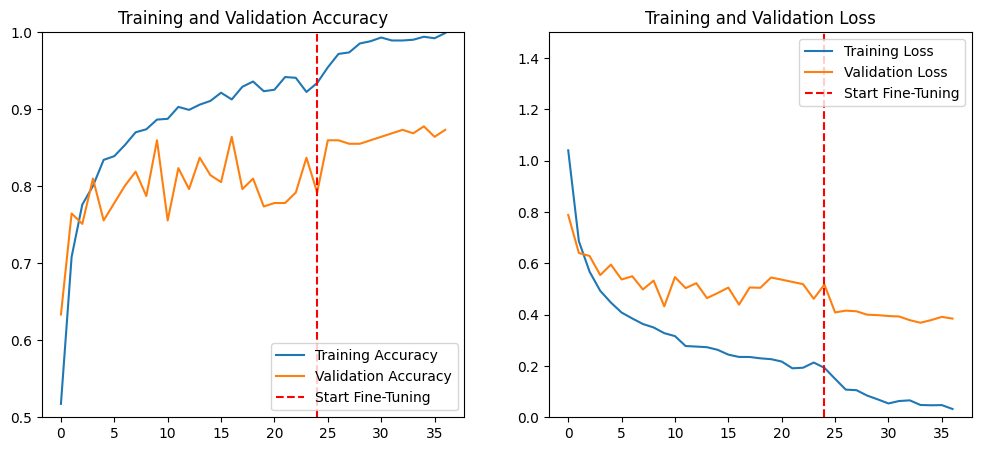


--- Evaluating the FINE-TUNED model on the unseen test set ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8732 - loss: 0.4300
Final Test Accuracy after Fine-Tuning: 89.19%


In [ ]:
# --- REPLACEMENT FOR CELL 7: Evaluate the FINE-TUNED Model ---

# Combine the history from the initial training and the fine-tuning phase
# Note: history.history is a dictionary, so we need to access its lists
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

# Plot the combined history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Add a vertical line to show where fine-tuning started
plt.axvline(epochs-1, linestyle='--', color='r', label='Start Fine-Tuning')
plt.ylim([0.5, 1.0])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# Add a vertical line to show where fine-tuning started
plt.axvline(epochs-1, linestyle='--', color='r', label='Start Fine-Tuning')
plt.ylim([0, 1.5])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# --- Evaluate on the Unseen Test Set ---
print("\n--- Evaluating the FINE-TUNED model on the unseen test set ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy after Fine-Tuning: {accuracy * 100:.2f}%")

In [ ]:
import os
from tensorflow import keras

def save_model_all_formats(model, drive_path="/content/drive/My Drive", base_name="TempleModel"):
    """
    Saves a Keras model in .keras, .h5, and SavedModel formats,
    and verifies that the files/folder exist.
    """
    # Paths
    keras_path = os.path.join(drive_path, base_name + ".keras")
    h5_path = os.path.join(drive_path, base_name + ".h5")
    savedmodel_path = os.path.join(drive_path, base_name + "_SavedModel")

    # Save in .keras format
    model.save(keras_path)
    print(f"Saved in Keras format: {keras_path} -> Exists? {os.path.exists(keras_path)}")

    # Save in .h5 format
    model.save(h5_path)
    print(f"Saved in H5 format: {h5_path} -> Exists? {os.path.exists(h5_path)}")

    # Save in SavedModel directory
    model.save(savedmodel_path)
    print(f"Saved in SavedModel format: {savedmodel_path} -> Exists? {os.path.isdir(savedmodel_path)}")

    return keras_path, h5_path, savedmodel_path


In [ ]:
from tensorflow import keras
import os

def load_any_model(path: str):
    """
    Loads a Keras model from .keras, .h5, or SavedModel folder.
    Automatically prints the model summary.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path not found: {path}")

    if path.endswith(".keras"):
        print("Loading .keras model...")
    elif path.endswith(".h5"):
        print("Loading .h5 model...")
    elif os.path.isdir(path):
        print("Loading SavedModel folder...")
    else:
        raise ValueError("Unsupported format. Use .keras, .h5, or SavedModel folder.")

    model = keras.models.load_model(path)
    print("Model loaded successfully.\n")

    # Print model summary
    model.summary()

    return model


In [ ]:
from tensorflow import keras
import os

# --- Set paths ---
drive_folder = "/content/drive/My Drive"
base_name = "TempleModel"

keras_path = os.path.join(drive_folder, base_name + ".keras")
h5_path = os.path.join(drive_folder, base_name + ".h5")
savedmodel_path = os.path.join(drive_folder, base_name + "_SavedModel")

# --- Save the model in all formats ---
print("Saving model in all formats...")

# Native Keras format (.keras)
model.save(keras_path)

# Legacy H5 format (.h5)
model.save(h5_path)

# TensorFlow SavedModel folder (use export in TF 3.x)
model.export(savedmodel_path)

print("Save complete.\n")

# --- Verify existence ---
print("Verifying saved files/folder:")
print(f".keras file exists? {os.path.exists(keras_path)}")
print(f".h5 file exists? {os.path.exists(h5_path)}")
print(f"SavedModel folder exists? {os.path.isdir(savedmodel_path)}")


Saving model in all formats...


Saved artifact at '/content/drive/My Drive/TempleModel_SavedModel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')]
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132206748498640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132206741456848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132206748499408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132206748499792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132206748498832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132206741457424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132206741457808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132206741458768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132206741458384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132206741457616: TensorSpec(shape=(), dtype=tf.

In [6]:
from tensorflow import keras

# Recommended: load .keras model
model = keras.models.load_model("/content/drive/My Drive/TempleModel.keras")
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,127,112 (15.74 MB)

 Trainable params: 1,865,283 (7.12 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 1,865,285 (7.12 MB)

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings # Import the warnings module

# Suppress specific deprecation warnings from matplotlib
warnings.filterwarnings("ignore", category=DeprecationWarning, module="matplotlib")


# --- Global Parameters (defined earlier in the notebook) ---
# Define these globally so they are accessible to the functions
img_height = 224
img_width = 224
class_names = ['Dravidian', 'Nagara', 'Vesara'] # Also defined earlier

# --- Helper Functions ---
def get_img_array(img_path, size):
    """Load any image and preprocess it to a model-ready array."""
    img = Image.open(img_path).convert("RGB")  # Ensure 3 channels
    img = img.resize(size)
    array = np.array(img, dtype=np.float32)
    array = np.expand_dims(array, axis=0)  # Add batch dimension
    return array

def display_gradcam(img_path, heatmap, alpha=0.4):
    """Overlay Grad-CAM heatmap on the original image."""
    img = Image.open(img_path).convert("RGB")
    img = np.array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = keras.utils.array_to_img(jet_colors[heatmap])
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img

def make_gradcam_heatmap(img_array, base_model, last_conv_layer_name='out_relu'):
    """
    Safe Grad-CAM: compute heatmap using only the MobileNetV2 base model.
    Avoids KeyError from top-level wrapper model.
    """
    img_tensor = tf.convert_to_tensor(img_array)
    img_tensor = tf.cast(img_tensor, tf.float32)
    img_tensor = preprocess_input(img_tensor)

    # Build model: input -> last conv layer output
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    grad_model = Model(inputs=base_model.input, outputs=last_conv_layer.output)

    with tf.GradientTape() as tape:
        conv_outputs = grad_model(img_tensor)
        # Simple scoring: sum over conv outputs as proxy for prediction
        class_channel = tf.reduce_sum(conv_outputs)

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

# --- Main Interactive Prediction Function ---
def predict_and_visualize_uploaded_image():
    print("\nPlease upload a temple image for analysis (any format supported by PIL).")
    uploaded = files.upload()

    if not uploaded:
        print("\nNo file was uploaded.")
        return

    filename = next(iter(uploaded))
    image_path = os.path.join("/content/", filename)
    print(f"\nAnalyzing '{filename}'...")

    # Preprocess image
    img_array = get_img_array(image_path, size=(img_height, img_width))

    # Reload the model and get the base model within the function scope
    try:
        model = keras.models.load_model("/content/drive/My Drive/TempleModel.keras")
        # Assuming the base model is the second layer (index 1) as in the Gradio cell
        base_model = model.layers[1]
        print("Model and base_model reloaded successfully within the function.")
    except Exception as e:
        print(f"Error reloading model within function: {e}")
        print("Please ensure '/content/drive/My Drive/TempleModel.keras' exists and rerun the cells defining the model.")
        return # Exit the function if model cannot be loaded

    preds = model.predict(img_array)
    scores = tf.nn.softmax(preds[0])

    print("\nPrediction Confidence:")
    for i, score in enumerate(scores):
        print(f"  - {class_names[i]}: {score*100:.2f}%")

    predicted_class = class_names[np.argmax(scores)]
    print("--------------------------------------------------")
    print(f"Final Prediction: ==> {predicted_class}")
    print("--------------------------------------------------")

    # Grad-CAM visualization (safe)
    # Need the base_model defined globally or passed in
    heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name='out_relu')
    superimposed_img = display_gradcam(image_path, heatmap)

    original_img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Uploaded Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM: Basis for '{predicted_class}' Prediction")
    plt.axis("off")

    plt.show()

Model and base_model reloaded successfully.

Please upload a temple image for analysis (any format supported by PIL).


Saving badrnath.jpg to badrnath (1).jpg

Analyzing 'badrnath (1).jpg'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Prediction Confidence:
  - Dravidian: 0.77%
  - Nagara: 71.78%
  - Vesara: 27.45%
--------------------------------------------------
Final Prediction: ==> Nagara
--------------------------------------------------


/tmp/ipython-input-55087666.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


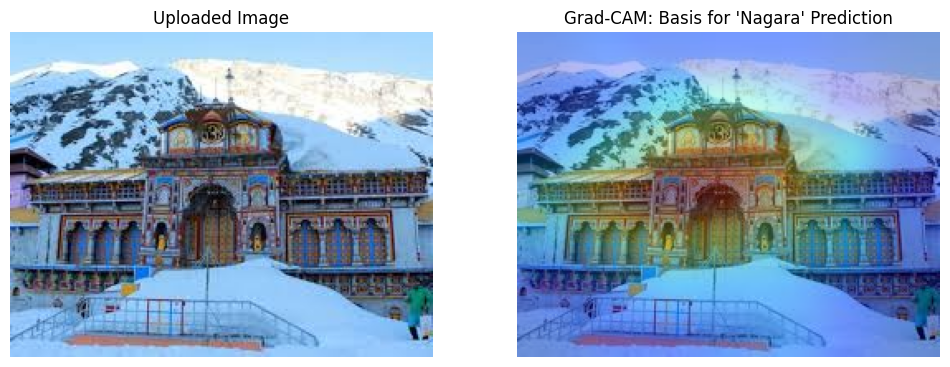

In [13]:
# Reload the model to ensure 'model' and 'base_model' are defined after a runtime disconnect/restart
try:
    model = keras.models.load_model("/content/drive/My Drive/TempleModel.keras")
    # Assuming the base model is the second layer (index 1) as in the Gradio cell
    base_model = model.layers[1]
    print("Model and base_model reloaded successfully.")
except Exception as e:
    print(f"Error reloading model: {e}")
    print("Please ensure '/content/drive/My Drive/TempleModel.keras' exists and rerun the cells defining the model.")
    # Exit or handle the error appropriately if model cannot be loaded

    pass # Or raise e

predict_and_visualize_uploaded_image()

In [ ]:
model.save("/content/drive/My Drive/TempleModel_final.keras", include_optimizer=False)


In [16]:
!pip install --upgrade gradio --quiet

import gradio as gr
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import cv2
import io

# --- Temple style metadata ---
style_info = {
    "Dravidian": {
        "description": "Dravidian architecture: South Indian temples, pyramid-shaped vimanas, intricate carvings.",
        "color": "#FFDDC1"
    },
    "Nagara": {
        "description": "Nagara architecture: North Indian temples, beehive-shaped shikharas, elaborate decoration.",
        "color": "#C1E1FF"
    },
    "Vesara": {
        "description": "Vesara architecture: Hybrid of Dravidian and Nagara styles, mainly in Deccan region.",
        "color": "#D5FFC1"
    }
}
class_names = ['Dravidian', 'Nagara', 'Vesara']

# --- Load model ---
model_path = "/content/drive/My Drive/TempleModel.keras"
model = tf.keras.models.load_model(model_path)
base_model = model.layers[1]  # MobileNetV2

# --- Grad-CAM helper functions ---
def get_img_array(img, size=(224,224)):
    img = img.convert("RGB").resize(size)
    array = np.array(img, dtype=np.float32)
    return np.expand_dims(array, axis=0)

def make_gradcam_heatmap(img_array, base_model, last_conv_layer_name='out_relu'):
    img_tensor = tf.convert_to_tensor(preprocess_input(img_array))
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    grad_model = Model(inputs=base_model.input, outputs=last_conv_layer.output)
    with tf.GradientTape() as tape:
        conv_outputs = grad_model(img_tensor)
        class_channel = tf.reduce_sum(conv_outputs)
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

# --- FIXED Grad-CAM visualization (Colab-style vivid colors) ---
def display_gradcam(img, heatmap, alpha=0.4):
    img_arr = np.array(img.convert("RGB"))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # vivid color map
    heatmap = cv2.resize(heatmap, (img_arr.shape[1], img_arr.shape[0]))
    superimposed_img = cv2.addWeighted(cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR), 0.6, heatmap, alpha, 0)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(superimposed_img)

def prediction_bar_chart(scores):
    plt.figure(figsize=(6,2))
    plt.bar(class_names, scores*100, color=['#FFDDC1','#C1E1FF','#D5FFC1'])
    plt.ylim(0,100)
    plt.ylabel("Confidence (%)")
    plt.title("Temple Style Probabilities")
    plt.xticks(fontsize=12)
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png', bbox_inches='tight', transparent=True)
    plt.close()
    buf.seek(0)
    return Image.open(buf)

# --- Main analysis function ---
def analyze_temple(img: Image.Image):
    img_array = get_img_array(img)
    preds = model.predict(img_array)
    scores = tf.nn.softmax(preds[0])

    heatmap = make_gradcam_heatmap(img_array, base_model)
    gradcam_img = display_gradcam(img, heatmap)

    predicted_class = class_names[np.argmax(scores)]
    pred_lines = [f"{style}: {scores[i]*100:.2f}%" for i, style in enumerate(class_names)]
    pred_text = f"<b>Predicted Style:</b> {predicted_class} ({scores[np.argmax(scores)]*100:.2f}%)<br>" + "<br>".join(pred_lines)

    metadata_html = f"""
    <div style="
        background-color: {style_info[predicted_class]['color']};
        padding: 15px;
        border-radius: 12px;
        font-family: 'Poppins', sans-serif;
        box-shadow: 2px 2px 12px rgba(0,0,0,0.4);
        width: 90%;
        margin:auto;
        text-align:center;
    ">
        <h3 style='margin-bottom:5px;'>Style: {predicted_class}</h3>
        <p style='margin:0px;'>{style_info[predicted_class]['description']}</p>
    </div>
    """

    bar_img = prediction_bar_chart(scores)
    return img, gradcam_img, bar_img, metadata_html, pred_text

# --- Custom CSS ---
custom_css = """
.gradio-container {
    background: rgba(255,255,255,0.85);
    backdrop-filter: blur(10px);
    border-radius: 20px;
    padding: 25px;
    max-width: 950px;
    margin: 70px auto;
    box-shadow: 0 8px 30px rgba(0,0,0,0.3);
}
h1 {
    text-align:center;
    color:#3B2F2F;
    font-family:'Poppins', sans-serif;
    font-size: 2.3em;
    margin-bottom: 25px;
}
button {
    font-family: 'Poppins', sans-serif;
}
"""

# --- Background Image via URL ---
background_url = "https://upload.wikimedia.org/wikipedia/commons/1/1d/Brihadeeswarar_Temple_Tanjore.jpg"
background_html = f"""
<div style="
    position: fixed;
    top:0;
    left:0;
    width:100%;
    height:100%;
    background-image: url('{background_url}');
    background-size: cover;
    background-position: center;
    background-attachment: fixed;
    filter: brightness(0.85) blur(1px);
    z-index:-1;
"></div>
"""

# --- Build Gradio Dashboard ---
with gr.Blocks(css=custom_css, title="Temple Architecture Dashboard") as demo:
    gr.HTML(background_html)
    gr.Markdown("<h1> Temple Architecture Analysis</h1>")

    with gr.Tab(" Prediction"):
        uploader = gr.Image(label="Upload Temple Image", type="pil")
        predict_btn = gr.Button("Analyze", variant="primary")

        with gr.Row():
            orig_output = gr.Image(label="Original Image")
            gradcam_output = gr.Image(label="Grad-CAM Visualization")

        bar_output = gr.Image(label="Prediction Probabilities")
        metadata_output = gr.HTML(label="Temple Metadata")
        text_output = gr.HTML(label="Prediction Scores")

        predict_btn.click(
            fn=analyze_temple,
            inputs=uploader,
            outputs=[orig_output, gradcam_output, bar_output, metadata_output, text_output]
        )

    with gr.Tab(" Visualization"):
        gr.Markdown("""
        ### Grad-CAM Visualization
        Grad-CAM highlights which regions of the image most influenced the model’s prediction.
        - **Red zones** indicate high model attention.
        - **Blue/Green** represent lower influence.
        """)

        gr.Markdown("""
        ### Confidence Bar Chart
        The bar chart shows the model’s confidence across the three temple styles:
        - Dravidian
        - Nagara
        - Vesara
        """)

    with gr.Tab(" About Project"):
        gr.Markdown("""
        ## Temple Architecture Analysis
        This AI model classifies Indian temples into **Dravidian**, **Nagara**, or **Vesara** styles based on their architectural design.
        It also visualizes the model’s reasoning using **Grad-CAM heatmaps**.

        **Developed by:** BATCH-17_CSM
        **Model:** MobileNetV2-based CNN
        **Framework:** TensorFlow + Gradio
        **Version:** 2.0 (Dashboard UI)
        """)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6ddeb7def5ccf6e5cf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
